In [1]:
# VISUALIZATION NOTEBOOK

# This notebook runs only the visualization of the results of a simulation for the Solar 
# Dynamo model with the sABC algorithm. The results of the simulation, as well as the parameters 
# used for the simulated data and the simulation itself are all stored in files in the directory 
# Simulations/Simulations i, and they are produced by the "simulations.ipynb" notebook.

# NB: The first thing to choose is which simulation to visualize; then it is all automatically done.
# There's no need to modify things, we can simply run the whole code so we know all the parameters
# used and all the graphs that we could be interested in.

# GG EZ - kallo27

In [2]:
using Plots
using Distributions
using Distances
using DataFrames
using CSV
using FFTW
using CairoMakie
using PairPlots

In [3]:
# FUNCTION FOR LOADING PARAMETERS AND RESULTS

# function for changing directory
function switch_dir(i::Int64 = 1)
  curr_path = pwd()
  directory = "Simulations/Simulation $i"
  path = joinpath(curr_path, directory)
  
  if isdir(path)
    cd(path)
    println("Moved to: $path")
  else
    throw(ErrorException("Directory does not exist: $path"))
  end
end

# function to load the parameters of the simulated data
function load_param_sim_data(filename::String = "parameters.csv")
  df = CSV.read(filename, DataFrame)
  return df
end

# function to load the saved solution of a SDDE
function load_solution(filename::String = "simulated_sol.csv"; plot::Bool = true)
  df = CSV.read(filename, DataFrame)

  t = Vector(df.Time)
  u = Vector(df.u)
  du = Vector(df.du)

  if plot 
    p = Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Simulated data", linewidth = 1)
    display(p)
    savefig(p, "simulated_data_plot.png")
  end

  return t, u, du
end

# function to load the parameters of the simulation
function load_param_sim(filename::String = "sabc_params.csv")
  df = CSV.read(filename, DataFrame)
  return df
end

# function to load the result object of a sABC algorithm
function load_result()
  curr_path = pwd()
  
  filenames = ["eps_hist.csv", "u_hist.csv", "rho_hist.csv"]
  variables = []
  for filename in filenames
      path = joinpath(curr_path, filename)
      push!(variables, CSV.read(path, DataFrame))
      println("Data loaded from file: $path")
  end
  eps_hist, u_hist, rho_hist = variables

  filename = "pop_hist.csv"
  path = joinpath(curr_path, filename)
  posterior_params = CSV.read(path, DataFrame)
  println("Posterior parameters loaded from file: $path")
  
  return eps_hist, u_hist, rho_hist, posterior_params
end

load_result (generic function with 1 method)

In [4]:
# FUNCTION FOR PLOTTING

# Function to plot the fourier spectrum of simulated data
function plot_fourier_spectrum(t::Vector{Float64}, u::Vector{Float64})
  Fs = 1 / (t[2] - t[1])
  N = length(u)
  freqs = fftfreq(N, Fs)

  fourier_transform_sim = abs.(fft(u))

  frequencies = freqs[(freqs .>= 0) .& (freqs .<= 0.5)]
  amplitudes = abs.(fourier_transform_sim[(freqs .>= 0) .& (freqs .<= 0.5)])


  p = Plots.plot(frequencies, amplitudes, xlabel="Frequency (Hz)", ylabel="Magnitude", title="Magnitude Spectrum", legend=false)
  display(p)
  savefig(p, "fourier_spectrum_sim.png")
end

# function for plotting u and epsilon behaviour in the sABC simulation
function u_eps_plot(eps_hist, u_hist)
  p1 = Plots.plot(vec(Matrix(eps_hist)), title="Epsilon History", xlabel="Iteration", legend=false, yscale=:log10)
  p2 = Plots.plot(vec(Matrix(u_hist)), title="U History", xlabel="Iteration", legend=false)

  combined_plot = Plots.plot(p1, p2, layout=(1, 2), size=(1000, 400))

  display(combined_plot)
  savefig(combined_plot, "u_eps_plot.png")
end

# function for plotting of rhos behaviour in the sABC simulation
function rho_plot(rho_hist; style::String = "together")
  if style == "divided"
    rho_plots = []

    for i in 1:20
      push!(rho_plots, Plots.plot(Matrix(rho_hist)[i, :], title="Rho History Stat $i", xlabel="Iteration", legend=false, yscale=:log10))
    end

    combined_plot = Plots.plot(rho_plots..., layout=(5, 4), size=(1200, 1800))

    display(combined_plot)
    savefig(combined_plot, "rho_divided.png")

  elseif style == "together"
    labels = ["rho$i" for i in 1:size(Matrix(rho_hist), 1)]

    all_rho_plot = Plots.plot(title="All Rho History", xlabel="Iteration", ylabel="Rho", legend=true, yscale=:log10)
    for i in 1:size(Matrix(rho_hist), 1)
      Plots.plot!(1:size(Matrix(rho_hist), 2), Matrix(rho_hist)[i, :], label=labels[i])
    end

    display(all_rho_plot)
    savefig(all_rho_plot, "rho_together.png")
  else
    throw(ErrorException("Invalid style: $style. The accepted styles are \"divided\" or \"together\""))
  end
end 

# Function for plotting the posterior as a corner plot
function post_plotting(post_par, true_vals)
  p = pairplot(
    posterior_params,
    PairPlots.Truth(
        (;
            N_value = true_vals[1],
            T_value = true_vals[2],
            tau_value = true_vals[3],
            sigma_value = true_vals[4],
            Bmax_value = true_vals[5]
        ),
        
        label="True Values"
    )
  )

  display(p)
  CairoMakie.save("posteriors.png", p)
end

post_plotting (generic function with 1 method)

In [6]:
# CHOICE OF THE DIRECTORY TO LOAD AND PLOT

# Current directory
initial_dir = pwd()

# Going into "Simulations/Simulation x"
x = 10
switch_dir(x)

# NB: Don't run again this cell!!! First go back to the starting directory.

ErrorException: Directory does not exist: /home/ubuntu/LCP_B/Project/Simulations/Simulation 10/Simulations/Simulation 10

In [7]:
# LOADING OF SIMULATED DATA PARAMETERS

sim_param = load_param_sim_data()

Row,Parameter,Value
,String7,String15
1,N,8.09897
2,T,4.51895
3,tau,3.63159
4,sigma,0.258871
5,B_max,7.81942
6,tspan,"[971, 1899]"
7,dt,0.01


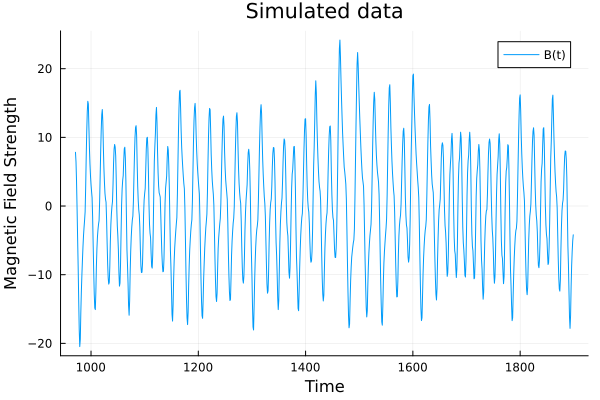

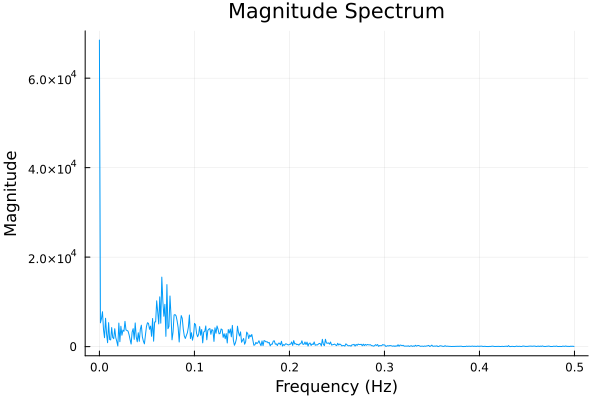

"/home/ubuntu/LCP_B/Project/Simulations/Simulation 10/fourier_spectrum_sim.png"

In [8]:
# VISUALIZATION OF SIMULATED DATA

# Solution of the SDDE
t, u, du = load_solution()

# Fourier spectrum
plot_fourier_spectrum(t, u.^2)

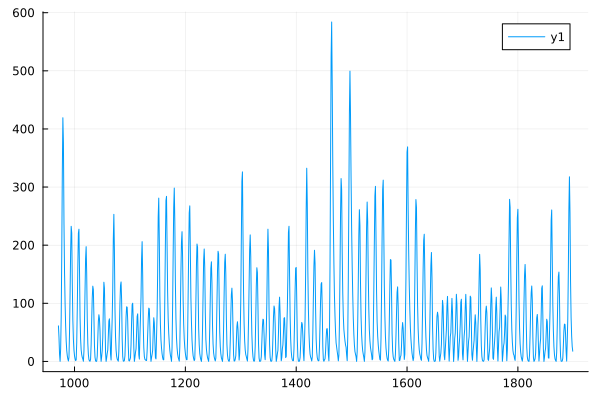

In [9]:
Plots.plot(t, u.^2)

In [20]:
# LOADING OF SIMULATION PARAMETERS

load_param_sim()

ArgumentError: ArgumentError: "sabc_params.csv" is not a valid file or doesn't exist

In [21]:
# LOADING AND PLOTTING OF SIMULATION RESULTS AND BEHAVIOUR

# Results loading 
eps_hist, u_hist, rho_hist, posterior_params = load_result()

# Epsilon, u and rho behaviour
u_eps_plot(eps_hist, u_hist)
rho_plot(rho_hist, style = "together")

ArgumentError: ArgumentError: "/home/ubuntu/LCP_B/Project/Simulations/Simulation 8/eps_hist.csv" is not a valid file or doesn't exist

In [22]:
# POSTERIORS PLOTTING

# Retrieving the "true" params used for the simulated data
true_values = [parse(Float64, val) for val in sim_param[1:5, 2]]

# Corner plot
post_plotting(posterior_params, true_values)

UndefVarError: UndefVarError: `posterior_params` not defined

In [9]:
# DIRECTORY MANAGING

# WE go back to the initial directory
cd(initial_dir)
pwd()

"/home/ubuntu/LCP_B/Project"